In [0]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def draw_disc(points, grid):
    """ Utility function: draws points on a poincare disk"""
    points, grid = map(check_numpy, (points, grid))
    fig, ax = plt.subplots(figsize=[10, 10])
    for r in sorted([0, 0.25, 0.5, 0.75, 1.0], reverse=True):
        ax.add_artist(plt.Circle((0, 0), radius=r, fill=False, edgecolor='black'))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.add_artist(ax.scatter(*zip(*points)))
    ax.imshow(grid.T, cmap='terrain', extent=[-1, 1, 1, -1])
    return ax

def check_numpy(x):
    """ Makes sure x is a numpy array """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x)
    assert isinstance(x, np.ndarray)
    return x

@torch.jit.script
def arccosh(x):
    """ Hyperbolic arc-cosine. x must be greater than 1. """
    eps = 1e-9
    value_under_sqrt = x ** 2 - 1.0
    value_under_sqrt = value_under_sqrt + (F.relu(value_under_sqrt) - value_under_sqrt).detach()
    return torch.log(x + torch.sqrt(value_under_sqrt + eps))

@torch.jit.script
def pseudo_polar_projection(x):
    """
    Projects arbitrary point on a d+1 dimensional hyperboloid
    :param x: [..., vector_dim]
    :return: [..., vector_dim + 1]
    """
    eps = 1e-9
    norm = torch.norm(x, p=2, dim=-1, keepdim=True)  #[..., 1]
    return torch.cat([torch.sinh(norm) * x / (norm + eps), torch.cosh(norm)], dim=-1)


@torch.jit.script
def lorentz_distance(x, y, curvature=torch.tensor(1.0)):
    """
    Computes lorentz distance between two points using pseudo_polar_projection
    :param x: second vector before projection, [..., vector_dim]
    :param y: first vector before projection, [..., vector_dim]
    :param curvature: larger curvature = more hyperbolic properties
    :returns: distances[...]
    """
    x = pseudo_polar_projection(x * curvature)
    y = pseudo_polar_projection(y * curvature)
    signs = 1 - 2 * (torch.arange(x.shape[-1], device=x.device) != (x.shape[-1] - 1)
                     ).to(torch.float32)

    return arccosh((x * y * signs).sum(-1)) / curvature
  
  
def kmeans(num_centroids, max_iter=100, print_every=10, learning_rate=1e-2, grid_size=1000, distance=lambda x, y: torch.norm(x - y, dim=-1)):
    centroids = nn.Parameter(torch.rand(num_centroids, 2).cuda() - 0.5)
    opt = torch.optim.Adam([centroids], lr=learning_rate)
    
    
    grid = torch.stack([
            torch.linspace(-1, 1, grid_size)[:, None].repeat(1, grid_size),
            torch.linspace(-1, 1, grid_size)[None, :].repeat(grid_size, 1)
    ], dim=-1).view(-1, 2).cuda()
    grid_mask = grid.norm(dim=-1) <= 1.0

    for i in trange(max_iter):
        distance_to_nearest_centroid = distance(centroids[:, None, :], grid[None, :, :]).min(dim=0)[0]
        loss = (distance_to_nearest_centroid * grid_mask.to(dtype=torch.float32)).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i % print_every == 0:
            clear_output(True)
            grid_centroid_id = distance(centroids[:, None, :], grid[None, :, :]).argmin(0)
            grid_labels = torch.where(grid_mask, grid_centroid_id, torch.full_like(grid_centroid_id, num_centroids)
                                     ).view(grid_size, grid_size)

            draw_disc(centroids, grid_labels)
            plt.show()
            print(loss.item())
            
    return centroids

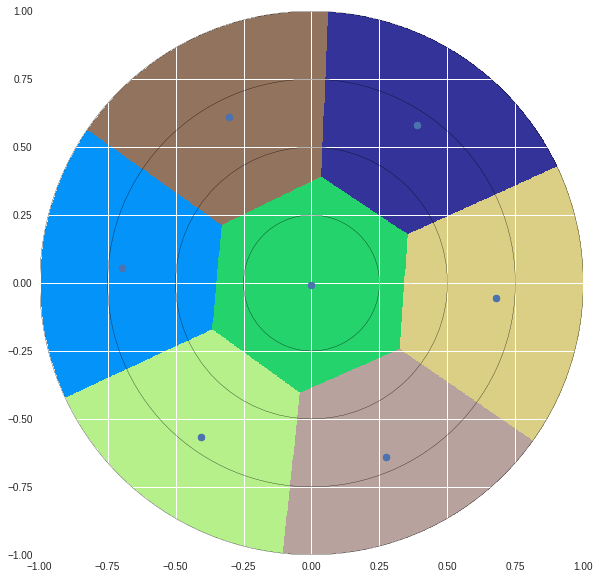

100%|██████████| 100/100 [00:13<00:00,  7.67it/s]

0.20275162160396576


Parameter containing:
tensor([[ 0.3812,  0.5745],
        [-0.6997,  0.0544],
        [-0.0026,  0.0008],
        [-0.4029, -0.5678],
        [ 0.6781, -0.0573],
        [-0.3025,  0.6183],
        [ 0.2862, -0.6302]], device='cuda:0', requires_grad=True)

In [6]:
# toy example: euclidian
kmeans(num_centroids=7, max_iter=100)


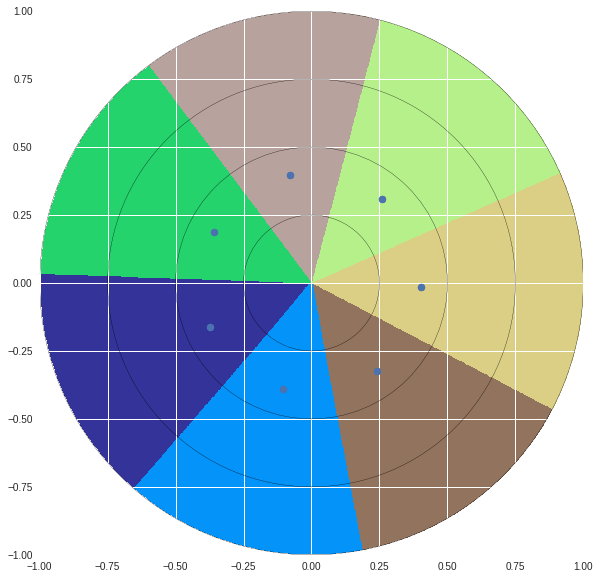

100%|██████████| 100/100 [00:10<00:00,  9.84it/s]

0.325591504573822


Parameter containing:
tensor([[-0.3727, -0.1631],
        [-0.1034, -0.3905],
        [-0.3591,  0.1889],
        [ 0.2633,  0.3091],
        [ 0.4051, -0.0127],
        [ 0.2424, -0.3246],
        [-0.0771,  0.3985]], device='cuda:0', requires_grad=True)

In [5]:
# toy example: lorentz k5
kmeans(num_centroids=7, max_iter=100, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(10.0)))

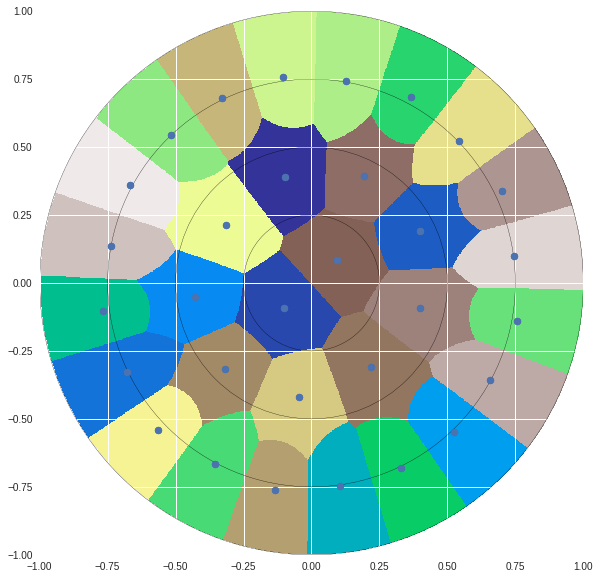

100%|██████████| 200/200 [00:51<00:00,  3.86it/s]

0.13231004774570465


Parameter containing:
tensor([[-0.0944,  0.3898],
        [-0.0997, -0.0924],
        [ 0.3976,  0.1918],
        [-0.6793, -0.3271],
        [-0.4273, -0.0490],
        [ 0.5232, -0.5468],
        [ 0.1056, -0.7457],
        [-0.7688, -0.1032],
        [ 0.3282, -0.6806],
        [ 0.3656,  0.6857],
        [-0.3534, -0.6659],
        [ 0.7569, -0.1389],
        [-0.5181,  0.5438],
        [ 0.1286,  0.7415],
        [-0.1055,  0.7578],
        [-0.3148,  0.2127],
        [-0.5629, -0.5406],
        [ 0.5432,  0.5231],
        [-0.0498, -0.4209],
        [-0.3307,  0.6791],
        [-0.1355, -0.7613],
        [-0.3194, -0.3151],
        [ 0.2156, -0.3091],
        [ 0.0928,  0.0853],
        [ 0.1931,  0.3927],
        [ 0.3979, -0.0922],
        [ 0.7014,  0.3383],
        [ 0.6584, -0.3581],
        [-0.7372,  0.1372],
        [ 0.7455,  0.0990],
        [-0.6694,  0.3613]], device='cuda:0', requires_grad=True)

In [8]:
# less toy...
kmeans(num_centroids=31, max_iter=200, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(10.0)))

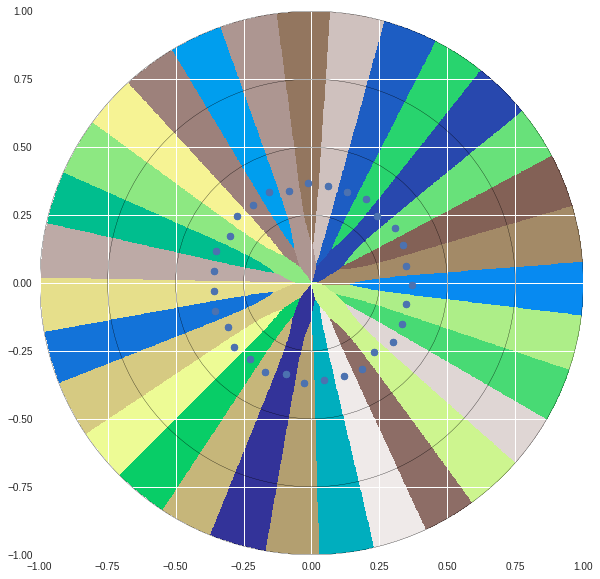

100%|██████████| 200/200 [00:52<00:00,  3.85it/s]

0.3121066689491272


Parameter containing:
tensor([[-0.0955, -0.3344],
        [ 0.2425,  0.2463],
        [ 0.1308,  0.3359],
        [-0.3552, -0.1017],
        [ 0.3680, -0.0077],
        [-0.1580,  0.3335],
        [ 0.0459, -0.3560],
        [-0.3504,  0.1162],
        [-0.2270, -0.2783],
        [ 0.1995,  0.3103],
        [ 0.3313, -0.1505],
        [ 0.3063,  0.2035],
        [-0.2997,  0.1736],
        [ 0.3483, -0.0789],
        [ 0.2310, -0.2537],
        [-0.2859, -0.2344],
        [-0.2753,  0.2463],
        [-0.3599, -0.0289],
        [-0.3076, -0.1612],
        [-0.1714, -0.3263],
        [-0.0268, -0.3676],
        [ 0.3461,  0.0640],
        [-0.0116,  0.3683],
        [ 0.3384,  0.1383],
        [ 0.1868, -0.3179],
        [-0.2158,  0.2887],
        [-0.0814,  0.3368],
        [-0.3594,  0.0439],
        [ 0.0605,  0.3564],
        [ 0.2989, -0.2157],
        [ 0.1182, -0.3430]], device='cuda:0', requires_grad=True)

In [9]:
kmeans(num_centroids=31, max_iter=200, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(10.0)))

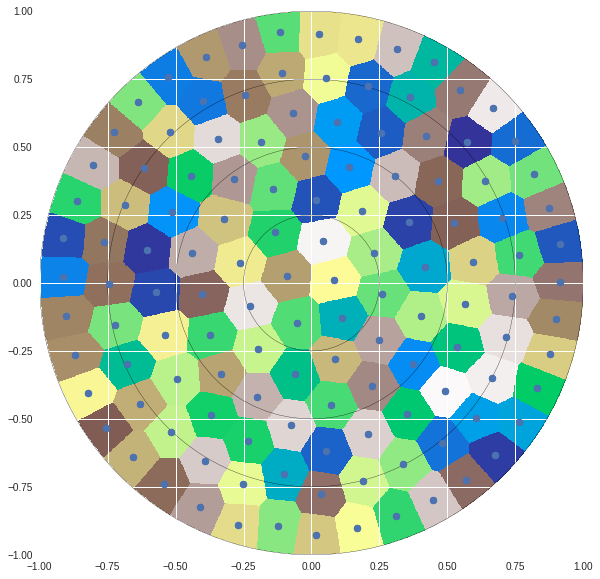

100%|██████████| 200/200 [03:19<00:00,  1.00it/s]

0.0488492026925087


Parameter containing:
tensor([[ 0.5697,  0.5181],
        [-0.6073,  0.1244],
        [ 0.6720, -0.6323],
        [ 0.3556,  0.2251],
        [-0.5745, -0.0323],
        [-0.9139,  0.1655],
        [ 0.0143,  0.3040],
        [ 0.9139,  0.1446],
        [ 0.2535,  0.5530],
        [ 0.0566, -0.6153],
        [ 0.2057,  0.7223],
        [ 0.7497,  0.5236],
        [ 0.4796, -0.5884],
        [-0.4029,  0.6685],
        [-0.5273,  0.7575],
        [-0.9150,  0.0225],
        [ 0.7003,  0.2409],
        [ 0.3769, -0.2952],
        [-0.5119,  0.2598],
        [ 0.1396,  0.4247],
        [ 0.0937,  0.5889],
        [ 0.6041, -0.4953],
        [ 0.7638, -0.5135],
        [ 0.4174,  0.0595],
        [-0.0993, -0.7020],
        [ 0.1147, -0.1284],
        [ 0.3613,  0.6861],
        [ 0.4503,  0.8119],
        [-0.6786, -0.3026],
        [-0.0603, -0.3341],
        [ 0.5400, -0.2346],
        [ 0.3538, -0.4792],
        [ 0.8290, -0.3874],
        [-0.4425,  0.3950],
        [-0.3672, -0.4835]

In [9]:
kmeans(num_centroids=127, max_iter=200, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(1.0)))

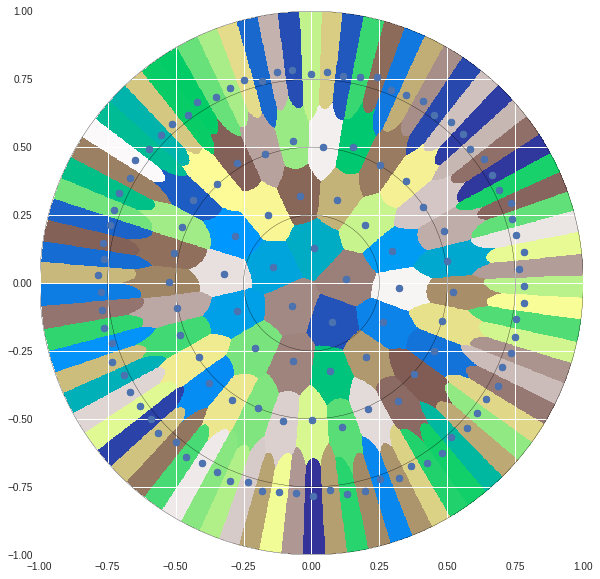

100%|██████████| 200/200 [03:19<00:00,  1.00it/s]

0.101927250623703


Parameter containing:
tensor([[ 6.3050e-03, -7.8372e-01],
        [ 6.6574e-01,  3.9707e-01],
        [ 5.5448e-01,  5.5243e-01],
        [-5.9295e-01, -4.9133e-01],
        [ 4.4992e-01,  6.1980e-01],
        [-7.0813e-02,  7.8437e-01],
        [ 7.3557e-02, -1.3820e-01],
        [ 1.0842e-01,  7.7275e-01],
        [-4.3599e-01,  3.1198e-01],
        [-7.4305e-01,  2.1196e-01],
        [-1.8778e-01,  7.4220e-01],
        [-7.6401e-01,  8.8383e-02],
        [ 4.5192e-01, -2.4807e-01],
        [ 2.8763e-01,  7.1350e-01],
        [-7.7587e-01, -3.5732e-02],
        [ 2.6237e-01, -1.4505e-01],
        [ 2.5025e-01, -7.1802e-01],
        [-3.7746e-01, -3.6837e-01],
        [-7.3411e-01, -2.2190e-01],
        [-2.8251e-01,  1.6869e-01],
        [ 2.9676e-01,  1.1527e-01],
        [-2.7497e-01, -1.1456e-01],
        [-1.4129e-01,  5.9329e-02],
        [ 4.9601e-01,  8.3203e-02],
        [ 8.4559e-03,  1.2910e-01],
        [-6.9443e-01, -3.3648e-01],
        [-5.5619e-01,  5.4419e-01],
      

In [10]:
kmeans(num_centroids=127, max_iter=200, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(5.0)))

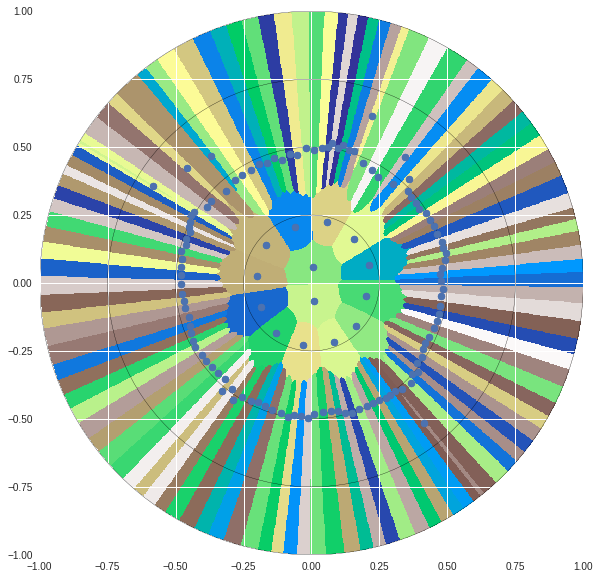

100%|██████████| 200/200 [03:20<00:00,  1.00s/it]

0.2311210334300995


Parameter containing:
tensor([[ 0.0950,  0.5055],
        [ 0.0489,  0.5182],
        [-0.0740,  0.4763],
        [-0.4688,  0.1564],
        [ 0.1516, -0.4778],
        [ 0.4726, -0.1100],
        [ 0.3935, -0.2935],
        [ 0.4599,  0.1787],
        [-0.4484,  0.2486],
        [-0.4656,  0.0228],
        [-0.1918, -0.0790],
        [ 0.4885,  0.0036],
        [ 0.3617, -0.3402],
        [-0.4518, -0.1567],
        [ 0.1413,  0.4910],
        [-0.1989,  0.4302],
        [-0.0705,  0.2055],
        [ 0.2959,  0.3719],
        [-0.0386, -0.4944],
        [ 0.4859,  0.0249],
        [ 0.2793, -0.4173],
        [-0.1593, -0.4573],
        [ 0.2595, -0.4373],
        [-0.3786,  0.4560],
        [ 0.2007,  0.0632],
        [-0.1714,  0.4329],
        [-0.1865, -0.4434],
        [ 0.3833,  0.2953],
        [ 0.0947, -0.4745],
        [ 0.1192,  0.5109],
        [ 0.4025,  0.2719],
        [ 0.2173, -0.4519],
        [-0.1419,  0.4521],
        [-0.0856, -0.4959],
        [ 0.0413, -0.4853]

In [8]:
kmeans(num_centroids=127, max_iter=200, distance=lambda a, b: lorentz_distance(a, b, curvature=torch.tensor(10.0)))